In [1]:
#1 import required modules
import time
import io
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.arff import loadarff

from sklearn.datasets import get_data_home
from sklearn.externals.joblib import Memory
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from urllib.request import urlopen

In [2]:


#2.  read the NMIST dataset
memory = Memory(get_data_home())
@memory.cache()
def fetch_mnist():
    content = urlopen(
        'https://www.openml.org/data/download/52667/mnist_784.arff').read()
    data, meta = loadarff(io.StringIO(content.decode('utf8')))
    data = data.view([('pixels', '<f8', 784), ('class', '|S1')])
    return data['pixels'], data['class']
X, y = fetch_mnist()

In [3]:
# rescale the data, use the traditional train/test split

X = X / 255.

###### NEW  Refromat the the labels to be integers rather than byte arrays
y_trans = []
for i in range(len(y)):
    y_trans.append(int(y[i]))
y = np.asarray(y_trans)

X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

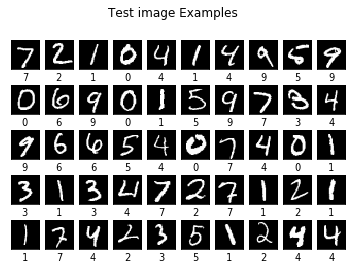

In [4]:
### Bounus 1: show the first 40 images
### ALways a good idea to validate that the data appears as you expect
### 
### for sci-kit learn the images are represented as vectors of 784 elements
### currently scaled from 0 to 1

for i in range(50):
    l1_plot = plt.subplot(5, 10, i + 1)
    l1_plot.imshow(255 * X_test[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.gray)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    #l1_plot.set_xlabel('Class %s' % y_test[i].decode())
    l1_plot.set_xlabel('%i' % int(y_test[i]))
plt.suptitle('Test image Examples')
plt.show()

In [6]:
## Data standardization
## by the mean and standared deviation of the training set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
#train and test classifier
# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50. / 1000,
                         multi_class='multinomial',
                         penalty='l1', solver='saga', tol=0.1)
# Train the classifier
clf.fit(X_train, y_train)

#Evaluate the classifier
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

Sparsity with L1 penalty: 16.35%
Test score with L1 penalty: 0.9023


In [32]:
""" Custom datatset loader
    based on https://github.com/utkuozbulak/pytorch-custom-dataset-examples
"""
import pandas as pd
import imageio

class SimpleDataset():
    def __init__(self, data_path, csv_name, transform = None ):
        """
        Args:
            data_path (string): path to the folder where images and csv files are located
            csv_name (string): name of the csv lablel file
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Set path
        self.data_path = data_path
        # Read the csv file
        self.data_info = pd.read_csv(data_path + csv_name, header=None)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        # Calculate len
        self.data_len = len(self.data_info.index)
        
    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        # Open image
        img_as_img = imageio.imread(self.data_path + single_image_name)
        
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]
        
        return (img_as_img, single_image_label)
    
    def __len__(self):
        return self.data_len

In [33]:
mydata = SimpleDataset( "./myDataSet/", "label.csv")

#splitting into images and labels 
X = []
y = []
for i in range(len(mydata)):
    X.append(mydata[i][0])
    y.append((mydata[i][1]))

#converting into numpy arrays to enable easy reshaping and other array operations
    
X = np.asarray(X)
print("Shape of the input image", X.shape)
y= np.asarray(y)

Shape of the input image (60, 28, 28)


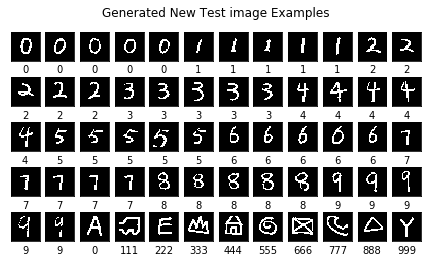

In [34]:
import warnings
warnings.filterwarnings('ignore')
#l1_plot = plt.subplot(12, 5, i + 1)
for i in range(60):
    l1_plot = plt.subplot(5, 12, i + 1)
    l1_plot.imshow(X[i], interpolation='nearest',
                   cmap=plt.cm.gray)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('%i' % int(y[i]))
plt.suptitle('Generated New Test image Examples')
plt.show()

In [26]:
#reshaping the array into flattened 784 array as an input for prediciton by the logistic regression classifier
X = X.reshape(X.shape[0], 784)
X = X / 255.
#data standardiation with the training set statistics is required for this clasifier
X = scaler.transform(X)

y_pred = clf.predict(X)

score = clf.score(X, y)

print("Test score with L1 penalty: %.4f" % score)
print("y_predicted_values", y_pred)
print("y_labels", y)

Test score with L1 penalty: 0.3000
y_predicted_values [9 9 9 9 9 1 1 1 1 1 8 8 9 2 2 3 3 3 3 3 8 9 8 8 8 8 8 9 8 8 8 8 8 6 8 1 1
 7 7 7 3 9 8 3 8 8 8 8 3 8 8 2 8 8 8 8 3 6 0 8]
y_labels [  0   0   0   0   0   1   1   1   1   1   2   2   2   2   2   3   3   3
   3   3   4   4   4   4   4   5   5   5   5   5   6   6   6   6   6   7
   7   7   7   7   8   8   8   8   8   9   9   9   9   9   0 111 222 333
 444 555 666 777 888 999]


In [27]:
## For analysis show also the confusion matrix

from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test)
cfm = confusion_matrix(y_test, y_predict)
print (cfm)

[[ 957    0    1    1    0    8    9    2    2    0]
 [   0 1104    2    3    1    2    4    0   19    0]
 [  15   16  888   24   16    1   12   21   35    4]
 [   5    4   19  901    1   32    6   17   17    8]
 [   2    8    4    0  916    2   12    2    3   33]
 [  15    5    4   41   17  743   20   14   25    8]
 [  16    6    7    0   12   19  894    1    3    0]
 [   1   25   18    5   12    0    1  928    1   37]
 [  11   23   10   26   19   33   11   17  810   14]
 [  16    8    3   13   48    7    0   28    4  882]]


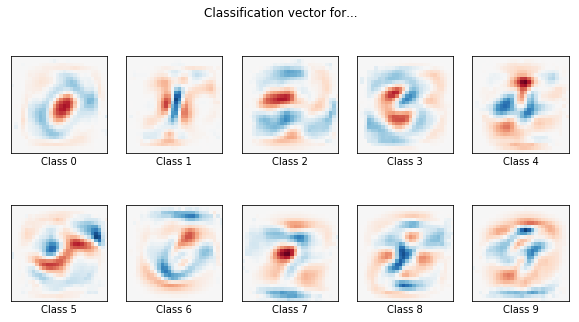

In [28]:
# Bonus 2: Visualization of the weights
# This is only possible for simple classifiers

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')
plt.show()

In [44]:
### Bonus 3: comfusion matrix visualization tool
## A more elegant preserntation for a confusion matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()
    plt.show()

Normalized confusion matrix


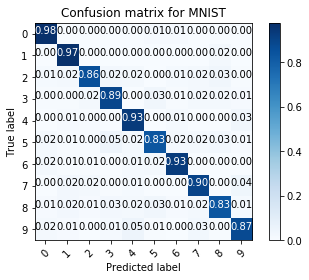

In [45]:
plot_confusion_matrix(cfm, classes=range(10), normalize=True,
                      title='Confusion matrix for MNIST')